# Constrained optimization: Penalty Method
-  **Giacomo Bacchetta**, <bacchetta.1840949@studenti.uniroma1.it>, LinkedIn: <https://www.linkedin.com/in/giacomobacchetta/>
-  **Edoardo Cesaroni**, <cesaroni.1841742@studenti.uniroma1.it>, LinkedIn: <https://www.linkedin.com/in/edoardocesaroni/>
-  **Fabio Ciccarelli**, <ciccarelli.1835348@studenti.uniroma1.it>, LinkedIn: <https://www.linkedin.com/in/fabio-ciccarelli-601399198/>

## Packages' import

Import of built-in python functions to compute gradient.
- $\bf{Autograd.numpy}$, equivalent to the better known numpy package;
- $\bf{Autograd}$, used to calculate the gradient (*grad*) of the functions taken into account;
- $\bf{AIL}$, which contains the Truncated Newthon Method as unconstrained opitimization method applied below;
- $\bf{matplotlib}$, which allows us to represent graphically the data.

In [1]:
import autograd.numpy as np
from autograd import grad
from AIL import nt
import matplotlib.pyplot as plt

## Karush-Kuhn-Tuckers's Conditions

This function allows to verify with an accuracy equal to $\epsilon$ how much a point respects the Karush-Kuhn-Tucker conditions that are the necessary conditions of first order for a constrained optimization problem.

In [2]:
def verify_KKT(f, g, h, x, lam, mu):
    epsilon = 1e-3
    
    kkt = grad(f)(x)+sum(lam[i]*grad(g[i])(x) for i in range(len(g))) + sum(mu[j]*grad(h[j])(x) for j in range(len(h)))
    
    for i in range(len(g)):
        if g[i](x) > epsilon or lam[i]*g[i](x) > epsilon or lam[i]*g[i](x) < -epsilon:
            return [False, np.linalg.norm(kkt)]
        
    for j in range(len(h)):
        if h[j](x) > epsilon or h[j](x) < -epsilon:
            return [False, np.linalg.norm(kkt)]

    if np.linalg.norm(grad(f)(x) + sum(grad(g[i])(x)*lam[i] for i in range(len(g))) + sum(grad(h[j])(x)*mu[j] for j in range(len(h)))) > epsilon:
        return [False, np.linalg.norm(kkt)]

    return [True, np.linalg.norm(kkt)]

## Other useful function

Before moving to the core of the algorithm, we defined the P function that replicates the quadratic penalty one.

In [3]:
def P(x):
    
    return f(x)+ (1/epsilon_p)*sum(max(0, g[i](x))**2 for i in range(len(g)))+ (1/epsilon_p)*sum(h[j](x)**2 for j in range(len(h)))

## Penalty Method

### Theory overview

The Penalty Method can be descrived as follows:

- **Step 0**. Given $x_0 \in R^n, \theta_1, \theta_2, \theta_3 \in(0,1), \varepsilon_{-1}=\varepsilon_0>0$ e $\delta_0>0$, we fix $k=0$.

$\newline$

- **Step 1**. We fix

$\newline$

$$
\begin{aligned}
\left(\lambda_k\right)_i &=\frac{2}{\varepsilon_{k-1}} \max \left\{0, g_i\left(x_k\right)\right\}, \quad i=1, \ldots, m \\
\left(\mu_k\right)_j &=\frac{2}{\varepsilon_{k-1}} h_j\left(x_k\right), \quad j=1, \ldots, p
\end{aligned}
$$

$\newline$

if KKT's conditions are satisfied by $\left(x_k, \lambda_k, \mu_k\right)$ , then STOP.

$\newline$

- **Step 2**. From the point $x_k$, we calculate the point $x_{k+1} \in R^n$ such that

$\newline$

$$
\| \nabla P\left(\left(x_{k+1} ; \varepsilon_k\right) \| \leq \delta_k .\right.
$$

$\newline$

- **Step 3**. If

$\newline$

$$
\sum_{i=1}^m \max \left\{0, g_i\left(x_{k+1}\right)\right\}^2+\sum_{j=1}^p h_j\left(x_{k+1}\right)^2 \leq \theta_1\left(\sum_{i=1}^m \max \left\{0, g_i\left(x_k\right)\right\}^2+\sum_{j=1}^p h_j\left(x_k\right)^2\right)
$$

$\newline$

we fix $\varepsilon_{k+1}=\varepsilon_k$ ,otherwise we fix $\varepsilon_{k+1}=\theta_2 \varepsilon_k$.

$\newline$

- **Step 4**. We fix $\delta_{k+1}=\theta_3 \delta_k, k=k+1$ and we back to the Step 1.

### Software implementation

In [4]:
def penalty_method(f, g, h, x):
    
    lam = []
    mu = []
    
    norm_grad = []
    
    global epsilon_p

    theta1 = 0.5
    theta2 = 0.5
    theta3 = 0.5
    delta = 10
    epsilon_prev = 0.1                 
    epsilon_current = 0.1
    epsilon_p = epsilon_current
    ite = 0
    
    
    while True:
        
        lam = []
        mu = []

        for i in range(len(g)):
            lam.append((max(0, g[i](x)))*(2/epsilon_prev))

        for j in range(len(h)):
            mu.append((h[j](x))*(2/epsilon_prev))

        norm_grad.append(verify_KKT(f, g, h, x, lam, mu)[1])
           
            
        if verify_KKT(f, g, h, x, lam, mu)[0] == True:
            print('Successful convergence to a local optimum \n x\u002A:', x.round(3), '\n f(x\u002A):', round(f(x), 4), '\n mu\u002A:', mu, '\n lambda\u002A:', lam)
            
            plt.plot(range(len(norm_grad)), norm_grad)
            plt.title('Speed of convergence', fontweight = 'bold')
            plt.xlabel('Iterations')
            plt.ylabel('Lagrangian norm')
            
            return x

        
        epsilon_p = epsilon_current

        x_succ = nt(P, x, delta)
    

        if sum(max(0, g[i](x_succ))**2 for i in range(len(g))) + sum((h[j](x_succ))**2 for j in range(len(h))) <= theta1*(sum(max(0, g[i](x))**2 for i in range(len(g))) + sum((h[j](x))**2 for j in range(len(h)))):
            epsilon_prev = epsilon_current
            epsilon_current = epsilon_current
            
        elif epsilon_current >= 1e-6: 
            epsilon_prev = epsilon_current
            epsilon_current = theta2 * epsilon_current
            
        elif epsilon_current < 1e-6:
            print('Successful convergence to a local optimum \n x\u002A:', x.round(3), '\n f(x\u002A):', round(f(x), 4), '\n mu\u002A:', mu, '\n lambda\u002A:', lam)
            
            plt.plot(range(len(norm_grad)), norm_grad)
            plt.title('Speed of convergence', fontweight = 'bold')
            plt.xlabel('Iterations')
            plt.ylabel('Lagrangian norm')
            
            return x_succ

        if delta > 1e-4:
            delta = delta * theta3
        x = x_succ
        
        ite = ite + 1

## Reliability tests

### Beale's Problem

$$
\begin{aligned}
f(x)= \ &9-8x_1-6x_2-4x_3+2x_1^2+2x_2^2+x_3^2+2x_1x_2+2x_1x_3\newline
s.t.\ & 3-x_1-x_2-2x_3 \geq 0 \newline
& 0 \leq x_i, i = 1,2,3 \newline
\newline
&x_0=[0.5, 0.5, 0.5]^T \newline 
&x^*=[\frac{4}{3},\frac{7}{9}, \frac{4}{9}]^T \newline 
&f\left(x^*\right)=\frac{1}{9}
\end{aligned}
$$

Successful convergence to a local optimum 
 x*: [1.333 0.778 0.445] 
 f(x*): 0.111 
 mu*: [] 
 lambda*: [0.22214344452684998, 0.0, 0.0, 0.0]


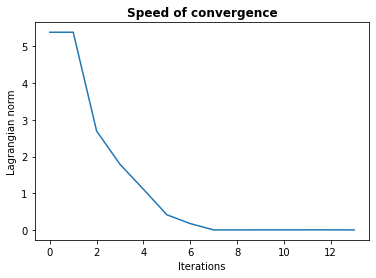

In [5]:
g = []
h = []

def f(x):
    return 9-8*x[0]-6*x[1]-4*x[2]+2*x[0]**2+2*x[1]**2+x[2]**2+2*x[0]*x[1]+2*x[0]*x[2]

def g1(x):
    return -(3-x[0]-x[1]-2*x[2]) 
g.append(g1)

def g2(x):
    return -(x[0]) 
g.append(g2)

def g3(x):
    return -(x[1]) 
g.append(g3)

def g4(x):
    return -(x[2]) 
g.append(g4)

x0 = np.array([0.5, 0.5, 0.5])


penalty_method(f, g, h, x0);

### HS 71

$$
\begin{aligned}
f(x)= \ &x_1x_4(x_1+x_2+x_3)+x_3\newline
s.t. \ & x_1x_2x_3x_4 - 25 = 0\newline
& x_1^2 + x_2^2 + x_3^2 + x_4^2 - 40 = 0\newline
& 1 \leq x_i \leq 5, i = 1,2,3, 4 \newline
\newline
&x_0=[1, 5, 5, 1]^T \newline 
&x^*=[1, 4.742994, 3.8211502, 1.3794082]^T \newline 
&f\left(x^*\right)=17.0140173
\end{aligned}
$$

Successful convergence to a local optimum 
 x*: [0.999 4.743 3.821 1.381] 
 f(x*): 17.0128 
 mu*: [0.1614833604253363] 
 lambda*: [0.5523182383103631, 0.0, 1.0857659920208107, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


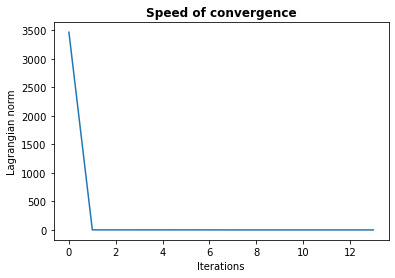

In [6]:
g = []
h = []

def f(x):
    return x[0]*x[3]*(x[0]+x[1]+x[2])+x[2]

def g1(x):
    return -((x[0]*x[1]*x[2]*x[3]) - 25.)
g.append(g1)

def h1(x):
    return ((((x[0])**2)+((x[1])**2)+((x[2])**2)+((x[3])**2)) - 40.)
h.append(h1)

def g2d(x):
    return x[0] - 5
g.append(g2d)

def g2s(x):
    return -(x[0] - 1)
g.append(g2s)

def g3d(x):
    return x[1] - 5
g.append(g3d)

def g3s(x):
    return -(x[1] - 1)
g.append(g3s)

def g4d(x):
    return x[2] - 5
g.append(g4d)

def g4s(x):
    return -(x[2] - 1)
g.append(g4s)

def g5d(x):
    return x[3] - 5
g.append(g5d)

def g5s(x):
    return -(x[3] - 1)
g.append(g5s)

x0 = np.array([1., 5., 5., 1.])  


penalty_method(f, g, h, x0);

### HS 76

$$
\begin{aligned}
f(x)= \ &x_1^2+0.5x_2^2+x_3^2+0.5x_4^2-x_1x_3+x_3x_4-x_1-3x_2+x_3-x_4\newline
s.t. \ & 5-x_1-2x_2-x_3-x_4 \geq 0\newline
& 4 - 3x_1 - x_2 - 2x_3 +x_4 \geq 0 \newline
& x_2 + 4x_3 - 1.5 \geq 0 \newline
& 0 \leq x_i , i = 1,2,3, 4 \newline
\newline
&x_0=[0.5, 0.5, 0.5, 0.5]^T \newline 
&x^*=[0.2727273, 2.090909, -0.26E^{10}, 0.5454545]^T \newline 
&f\left(x^*\right)= - 4.6818181
\end{aligned}
$$

Successful convergence to a local optimum 
 x*: [ 0.273  2.091 -0.     0.546] 
 f(x*): -4.6824 
 mu*: [] 
 lambda*: [0.45449936106535915, 0.0, 0.0, 0.0, 0.0, 1.7270817910756555, 0.0]


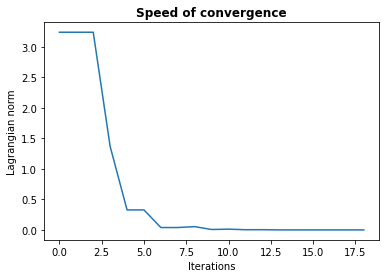

In [7]:
g = []
h = []

def f(x):
    return x[0]**2 + 0.5*(x[1]**2) + x[2]**2 + 0.5*(x[3]**2) - (x[0]*x[2]) + (x[2]*x[3]) - x[0] - 3*x[1] + x[2] - x[3]

def g1(x):
    return -(5. - x[0] - 2*x[1] - x[2] - x[3])
g.append(g1)

def g2(x):
    return -(4. - 3.*x[0] - x[1] - 2.*x[2] + x[3])
g.append(g2)

def g3(x):
    return -(x[1] + 4. * x[2] - 1.5)
g.append(g3)

def g4(x):
    return -x[0]
g.append(g4)

def g5(x):
    return -x[1]
g.append(g5)

def g6(x):
    return -x[2]
g.append(g6)

def g7(x):
    return -x[3]
g.append(g7)

x0 = np.array([.5, .5, .5, .5])


penalty_method(f, g, h, x0);

### HS 100

$$
\begin{aligned}
f(x)=\ & \left(x_1-10\right)^2+5\left(x_2-12\right)^2+x_3^4+3\left(x_4-11\right)^2 +10 x_5{ }^6+7 x_6^2+x_7^4-4 x_6 x_7-10 x_6-8 x_7 \newline
s.t. \ & 127-2x_1^2-3x_2^4-x_3-4x_4^2-5x_5 \geq 0 \newline
& 282 - 7x_1 - 3x_2 - 10x_3^2 -x_4 + x_5 \geq 0 \newline
& 196 - 23x_1 - x_2^2 - 6x_6^2 + 8x_7 \geq 0 \newline
&-4x_1^2-x_2^2+3x_1x_2-2x_3^2-5x_6+11x_7 \geq 0 \newline
\newline
&x_0=[1, 2, 0, 4, 0, 1, 1]^T \newline 
&x^*=[2.330499, 1.951372, -4.775414, 4.365726, -0.6244870, 1.039121, 1.594227]^T \newline 
&f\left(x^*\right)= 680.6300573
\end{aligned}
$$

Successful convergence to a local optimum 
 x*: [ 2.331  1.951 -0.478  4.366 -0.624  1.038  1.594] 
 f(x*): 680.6295 
 mu*: [] 
 lambda*: [1.139720432198601, 0.0, 0.0, 0.36863051533146063]


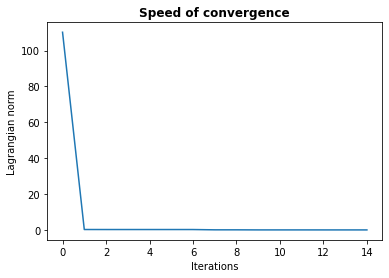

In [8]:
g = []
h = []

def f(x):
    return (x[0] - 10.)**2 + 5.*(x[1]-12.)**2 + x[2]**4 + 3*(x[3] - 11.)**2 + 10.*x[4]**6 + 7.*x[5]**2 + x[6]**4 - 4.*x[5]*x[6] - 10*x[5] - 8.*x[6]

def g1(x):
    return -(127 -2*x[0]**2 -3*x[1]**4 - x[2] - 4*x[3]**2 - 5*x[4])
g.append(g1)

def g2(x):
    return -(282 - 7*x[0] - 3*x[1] -10*x[2]**2 -x[3] + x[4])
g.append(g2)

def g3(x):
    return -(196 - 23*x[0] - x[1]**2 -6*x[5]**2+8*x[6])
g.append(g3)

def g4(x):
    return -(-4*x[0]**2 -x[1]**2 +3*x[0]*x[1] -2*x[2]**2 -5*x[5] + 11*x[6])
g.append(g4)

x0 = np.array([1., 2., 0., 4., 0., 1., 1.])


penalty_method(f, g, h, x0);

### HS 108


$$
\begin{aligned}
f(x)= \ & -0.5(x_1x_4 - x_2x_3 + x_3x_9 - x_5x_9 + x_5x_8 - x_6x_7)\newline
s.t. \ & 1 - x_3^2 - x_4 ^ 2 \geq 0 \newline
& 1 - x_5^2 - x_6 ^ 2 \geq 0 \newline
& 1 - x_9^2 \geq 0 \newline
& 1 - x_1^2 - (x_2 -x_9)^2 \geq 0 \newline
& 1 - (x_1-x_5)^2 - (x_2-x_6)^2 \geq 0 \newline
& 1 - (x_1-x_7)^2 - (x_2-x_8)^2 \geq 0 \newline
& 1 - (x_3-x_5)^2 - (x_4-x_6)^2 \geq 0 \newline
& 1 - (x_3-x_7)^2 - (x_4-x_8)^2 \geq 0 \newline
& 1 - x_7^2 - (x_8 -x_9)^2 \geq 0 \newline
& x_3x_9 \geq 0 \newline
& x_1x_4 - x_2x_3 \geq 0 \newline
& x_3x_9 \geq 0 \newline
& -x_5x_9 \geq 0 \newline
& x_5x_8 - x_6x_7 \geq 0 \newline
& 0 \leq x_9 \newline
\newline
&x_0=[1, 1, 1, 1, 1, 1, 1, 1, 1]^T \newline 
&x^*=[0.8841292, 0.4672425, 0.0374076, 0.9992996, 0.8841292, 0.4672424, 0.03722076, 0.9992996, 0.26E^{-19}]^T \newline 
&f\left(x^*\right)= -0.8660254038
\end{aligned}
$$

Successful convergence to a local optimum 
 x*: [ 0.943  0.332  0.184  0.983  0.943  0.333  0.184  0.983 -0.   ] 
 f(x*): -0.8661 
 mu*: [] 
 lambda*: [0.14434496036415112, 0.1443308943404098, 0.0, 0.14433777795005653, 0.14433394707388914, 0.0, 0.07217266267630862, 0.07217266267630862, 0.0, 0.0, 0.1443408850083472, 0.0, 0.0, 1.9036435334339376e-05]


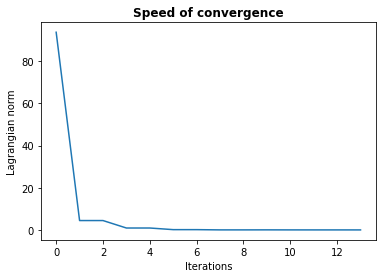

In [9]:
g = []
h = []

def f(x):
    return -0.5*(x[0]*x[3]-x[1]*x[2]+x[2]*x[8]-x[4]*x[8]+x[4]*x[7]-x[5]*x[6])

def g1(x):
    return -(1-x[2]**2-x[3]**2)
g.append(g1)

def g2(x):
    return -(1-x[4]**2-x[5]**2)
g.append(g2)

def g3(x):
    return -(1-(x[0]-x[4])**2-(x[1]-x[5])**2)
g.append(g3)

def g4(x):
    return -(1-(x[0]-x[6])**2-(x[1]-x[7])**2)
g.append(g4)

def g5(x):
    return -(1-(x[2]-x[4])**2-(x[3]-x[5])**2)
g.append(g5)

def g6(x):
    return -(1-(x[2]-x[6])**2-(x[3]-x[7])**2)
g.append(g6)

def g7d(x):
    return -(1-x[6]**2-(x[7]-x[8])**2)
g.append(g7d)

def g7s(x):
    return -(x[2]*x[8])
g.append(g7d)

def g8d(x):
    return -(x[4]*x[7]-x[5]*x[6])
g.append(g8d)

def g8s(x):
    return -(1-x[8]**2)
g.append(g8s)

def g9d(x):
    return -(1-x[0]**2-(x[1]-x[8])**2)
g.append(g9d)

def g9s(x):
    return -(x[0]*x[3]-x[1]*x[2])
g.append(g9s)

def g10d(x):
    return x[4]*x[8]
g.append(g10d)

def g10s(x):
    return -x[8]
g.append(g10s)

x0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])


penalty_method(f, g, h, x0);